In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
from ortools.linear_solver import pywraplp

# Systems Simulation and Modeling Project

## Optimization Linear Programming
## Vehicle routing optimization

###### Objective function
We would want to minimize the total traveling distance of all vehicle
$$minimize \sum_{k=1}^{K} \sum_{i=0}^{N} \sum_{j=0}^{N} d_{ij}^{k}x_{ij}^{k}$$
###### constraint 1
Each location will be visited only once
$$\sum_{k=1}^{K}\sum_{i=0, i\ne j}^{N} x_{ij}^{k} = 1, \forall j=1,...,N$$
###### constraint 2
Constraint 2 ensure that the initial point of each vehicle is the distribution center or they start from the depot.
$$\sum_{j=1}^{N} x_{0j}^{k} = 1, \forall k$$
###### constraint 3
Constraint 3 ensure that each vehicle should return to the depot at the end.
$$\sum_{i=1}^{N} x_{i0}^{k} = 1, \forall k$$
###### constraint 4
The value of incoming flow is same as outgoing flow.
$$\sum_{i=0}^{N} x_{it}^{k} - \sum_{j=0}^{N} x_{tj}^{k} = 0, \forall k, \forall t$$
###### constraint 5
The distance traveled of each vehicle should not exceed maximum distance.
$$\sum_{i=0}^{N}\sum_{j=0}^{N} d_{ij}x_{ij}^{k} \leq D, \forall k$$
###### constraint 6
The quantity of goods delivered must not exceed the capacity of the vehicle. \
For simplicity, in this constraint, I assume that quantity of goods for each location is 1.
$$\sum_{i=0}^{N}\sum_{j=0}^{N} q_{j}x_{ij}^{k} \leq Q, \forall k$$
###### constraint 7
Subtours elimination, the routes must be connected.
$$\sum_{k=1}^{K}\sum_{i \in S}\sum_{j \in S} x_{ij}^{k} \leq |S| - 1, \forall k$$

$$x_{ij}^{k} = 0, 1  \forall k, \forall i, \forall j$$

References \
https://bib.irb.hr/datoteka/433524.Vehnicle_Routing_Problem.pdf \
https://www.sciencedirect.com/science/article/pii/S2405896318313296 \
https://medium.com/jdsc-tech-blog/capacitated-vehicle-routing-problem-cvrp-with-python-pulp-and-google-maps-api-5a42dbb594c0

In [2]:
np.random.seed(777)
dim = 20
vehicle_count = 3
locations_count = 10
max_distance = 40
vehicle_capacity = 4
locations = np.zeros((locations_count, 2))
locations[0] = [dim/2, dim/2]
count = 1
while(count < locations_count):
    x, y = np.random.randint(0, dim-1), np.random.randint(0, dim-1)
    xy = np.array([x,y])
    if not np.any(np.all(xy == locations, axis=1)): # if it is unique (x,y) coordinates, then add to locations
        locations[count] = [x,y] 
        count+=1

# quantity of goods that need to delivery to each location
demand = [ 1 for i in range(locations_count) ]
demand[0] = 0

In [3]:
xs, ys = locations.T
center = locations[0]

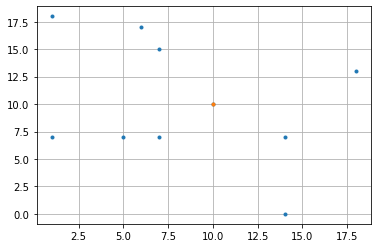

In [4]:
plt.plot(xs, ys, '.')
plt.plot(center[0], center[1], '.')
plt.grid()

In [5]:
def distance(p1, p2):
    x1, x2 = p1[0], p2[0]
    y1, y2 = p1[1], p2[1]
    return math.hypot(x2 - x1, y2 - y1)

In [6]:
distance_matrix = [[distance(locations[i], locations[j]) 
                    for i in range(locations_count)] 
                    for j in range(locations_count)]
distance_matrix

[[0.0,
  5.8309518948453,
  8.06225774829855,
  4.242640687119286,
  5.0,
  8.54400374531753,
  10.77032961426901,
  12.041594578792296,
  5.8309518948453,
  9.486832980505138],
 [5.8309518948453,
  0.0,
  2.23606797749979,
  8.0,
  10.63014581273465,
  11.180339887498947,
  16.55294535724685,
  6.708203932499369,
  8.246211251235321,
  10.0],
 [8.06225774829855,
  2.23606797749979,
  0.0,
  10.04987562112089,
  12.806248474865697,
  12.649110640673518,
  18.788294228055936,
  5.099019513592785,
  10.04987562112089,
  11.180339887498949],
 [4.242640687119286,
  8.0,
  10.04987562112089,
  0.0,
  7.0,
  12.529964086141668,
  9.899494936611665,
  12.529964086141668,
  2.0,
  6.0],
 [5.0,
  10.63014581273465,
  12.806248474865697,
  7.0,
  0.0,
  7.211102550927979,
  7.0,
  17.029386365926403,
  9.0,
  13.0],
 [8.54400374531753,
  11.180339887498947,
  12.649110640673518,
  12.529964086141668,
  7.211102550927979,
  0.0,
  13.601470508735444,
  17.720045146669353,
  14.317821063276352,
  

In [7]:
distance(center, locations[1])

5.8309518948453

In [8]:
print(center)
print(locations[1])

[10. 10.]
[ 7. 15.]


In [9]:
solver = pywraplp.Solver.CreateSolver('SAT')

# Decision variables
x = [[[solver.IntVar(0, 1, 'x_%s_%s,%s'%(i, j, k)) 
        for k in range(vehicle_count)] 
        for j in range(locations_count)] 
        for i in range(locations_count)]

# Objective function
objective_terms = [ distance_matrix[i][j] * x[i][j][k]
                   for i in range(locations_count) 
                   for j in range(locations_count) 
                   for k in range(vehicle_count) ]

solver.Minimize(solver.Sum(objective_terms))

In [10]:
# constraint 1
for j in range(1, locations_count):
    constraint1 = [ x[i][j][k]
                   for k in range(vehicle_count) 
                   for i in range(locations_count) if i!=j ]
    solver.Add(solver.Sum(constraint1) == 1)
    
# constraint 2
for k in range(vehicle_count):
    constraint2 = [x[0][j][k] for j in range(1, locations_count)]
    solver.Add(solver.Sum(constraint2) == 1)

# constraint 3
for k in range(vehicle_count):
    constraint3 = [x[i][0][k] for i in range(1, locations_count)]
    solver.Add(solver.Sum(constraint3) == 1)
    
# constraint 4
for k in range(vehicle_count):
    for t in range(locations_count):
        in_coming = [x[i][t][k] for i in range(locations_count) if i!=t]
        out_going = [x[t][j][k] for j in range(locations_count) if j!=t]
        solver.Add((solver.Sum(in_coming) - solver.Sum(out_going)) == 0)
        
# constraint 5
for k in range(vehicle_count):
    constraint5 = [ distance_matrix[i][j] * x[i][j][k] 
                   for i in range(locations_count)
                   for j in range(locations_count) ]
    solver.Add(solver.Sum(constraint5) <= max_distance)

# constraint 6
for k in range(vehicle_count):
    constraint6 = [ demand[j]*x[i][j][k] for i in range(locations_count) for j in range(locations_count) if i!=j ]
    solver.Add(solver.Sum(constraint6) <= vehicle_capacity)

# constraint 7
# subtour elimination
subtours = []
for i in range(2, locations_count):
     subtours += itertools.combinations(range(1, locations_count), i)

for s in subtours:
    constraint7 = [x[i][j][k] for i in s 
                   for j in s 
                   for k in range(vehicle_count) if i!=j]
    solver.Add(solver.Sum(constraint7) <= (len(s)-1))

In [11]:
solver.Solve()

0

In [12]:
solver.Objective().Value()

78.46254354715347

In [13]:
print(x[0][0][1].solution_value())

1.0


In [14]:
def plot_graph(locations, vehicle_count, locations_count):
    for k in range(vehicle_count):
        for i in range(locations_count):
            for j in range(locations_count):
                if i!=j and x[i][j][k].solution_value() == 1:
                    plt.plot([locations[i][0], locations[j][0]], [locations[i][1], locations[j][1]], c='black')

In [15]:
print("Minimum total traveling distance =", solver.Objective().Value())

Minimum total traveling distance = 78.46254354715347


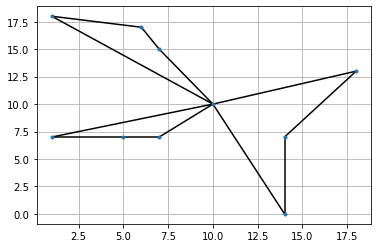

In [16]:
plot_graph(locations, vehicle_count, locations_count)
plt.plot(xs, ys, '.')
plt.grid()